# Variational Autoencoder
#
This notebook implements a Variational Autoencoder (VAE) to compress and reconstruct tas from the ClimateBench dataset. The VAE learns a low-dimensional latent space from the high-dimensional field, allowing both downsampling and upsampling of data. We won't be conditioning on CO2/CH4 yet... this notebook is simply compressing and decompressing the temperature field. Think of it as a non-linear PCA. In the CNN_VAE_example notebook, we will see an example that uses CO2/CH4 to condition a convolutional VAE.

For now, the focus is to understand the VAE architecture.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. Data preprocssing

We load and preprocess the climate data from the ClimateBench dataset. We aren't using CO2/CH4 as inputs here. The temperature fields (tas) are flattened and split into training, validation, and test sets. 

In [4]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

# dimensions are used to make evaluation plots
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
y_train = y_train_xr['tas'].data
y_test = y_test_xr['tas'].data

y_train_flat = y_train.reshape(y_train.shape[0], -1)  # (n_samples, n_lat*n_lon)
y_test_flat = y_test.reshape(y_test.shape[0], -1)

n_lat, n_lon = y_train.shape[1], y_train.shape[2]
input_dim = n_lat * n_lon

In [6]:
# Convert to PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(y_train_flat))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(y_test_flat))

# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

### 2. Define the VAE architecture
Here we build the encoder, decoder, and reparameterization modules. The encoder compresses the input into a latent representation, the decoder reconstructs the input, and the reparameterization trick allows gradient-based training through stochastic sampling.

In [7]:
# Hyperparameters
latent_dim = 1
learning_rate = 0.001
minibatch_size = 64
num_epochs = 50

# Data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=minibatch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=minibatch_size, shuffle=False
)

print(f"Input dimension: {input_dim}")
print(f"Latent dimension: {latent_dim}")
print(f"y_train_flat shape: {y_train_flat.shape}")

Input dimension: 13824
Latent dimension: 1
y_train_flat shape: (753, 13824)


#### Build Encoder & Sampling for the latent vector

In [8]:
class VAEEncoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, hidden_dims=(128, 32)):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        self.net = nn.Sequential(*layers)
        self.fc_mu = nn.Linear(in_dim, latent_dim)
        self.fc_logvar = nn.Linear(in_dim, latent_dim)

    def forward(self, x):
        h = self.net(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class VAEDecoder(nn.Module):
    def __init__(self, output_dim: int, latent_dim: int, hidden_dims=(32, 128)):
        super().__init__()
        layers = []
        in_dim = latent_dim
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        return self.net(z)

class VAE(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int,
                 enc_hidden=(128, 32), dec_hidden=(32, 128)):
        super().__init__()
        self.encoder = VAEEncoder(input_dim, latent_dim, hidden_dims=enc_hidden)
        self.decoder = VAEDecoder(input_dim, latent_dim, hidden_dims=dec_hidden)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

In [9]:
vae = VAE(latent_dim = latent_dim, input_dim = input_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

In [10]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# 3. Train the VAE model

We train the VAE using a combination of reconstruction loss (mean squared error) and KL divergence (regularizing the latent space). Early stopping is applied based on validation loss to prevent overfitting.

In [11]:
def pytorch_train_VAE(model, optimizer, criterion, device, num_epochs, train_loader, val_loader):
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 20
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):

        model.train()
        train_loss = 0.0
        for (batch_y,) in train_loader:
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(batch_y)
            loss = criterion(recon, batch_y, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for (batch_y,) in val_loader:
                batch_y = batch_y.to(device)
                recon, mu, logvar = model(batch_y)
                loss = criterion(recon, batch_y, mu, logvar)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    return train_losses, val_losses

In [12]:
train_losses, val_losses = pytorch_train_VAE(vae.to(device), optimizer, criterion = vae_loss, 
                                             device = device, 
                                         train_loader = train_loader, 
                                         val_loader = val_loader, 
                                         num_epochs = num_epochs)

Epoch 1/50, Train Loss: 4047.0031, Val Loss: 20.0579
Epoch 2/50, Train Loss: 9.9551, Val Loss: 4.4633
Epoch 3/50, Train Loss: 4.5610, Val Loss: 4.4328
Epoch 4/50, Train Loss: 4.6658, Val Loss: 3.7738
Epoch 5/50, Train Loss: 3.7617, Val Loss: 2.6600
Epoch 6/50, Train Loss: 2.8815, Val Loss: 2.2072
Epoch 7/50, Train Loss: 2.5317, Val Loss: 2.0913
Epoch 8/50, Train Loss: 2.3578, Val Loss: 1.9108
Epoch 9/50, Train Loss: 2.1198, Val Loss: 1.5980
Epoch 10/50, Train Loss: 2.0947, Val Loss: 1.7300
Epoch 11/50, Train Loss: 1.8661, Val Loss: 1.6162
Epoch 12/50, Train Loss: 1.9140, Val Loss: 1.6051
Epoch 13/50, Train Loss: 1.7355, Val Loss: 1.4627
Epoch 14/50, Train Loss: 1.8476, Val Loss: 1.5161
Epoch 15/50, Train Loss: 1.6384, Val Loss: 1.5494
Epoch 16/50, Train Loss: 1.7136, Val Loss: 1.4090
Epoch 17/50, Train Loss: 1.6319, Val Loss: 1.5814
Epoch 18/50, Train Loss: 1.5979, Val Loss: 1.4189
Epoch 19/50, Train Loss: 1.5847, Val Loss: 1.4149
Epoch 20/50, Train Loss: 1.6453, Val Loss: 1.3774
Epoch

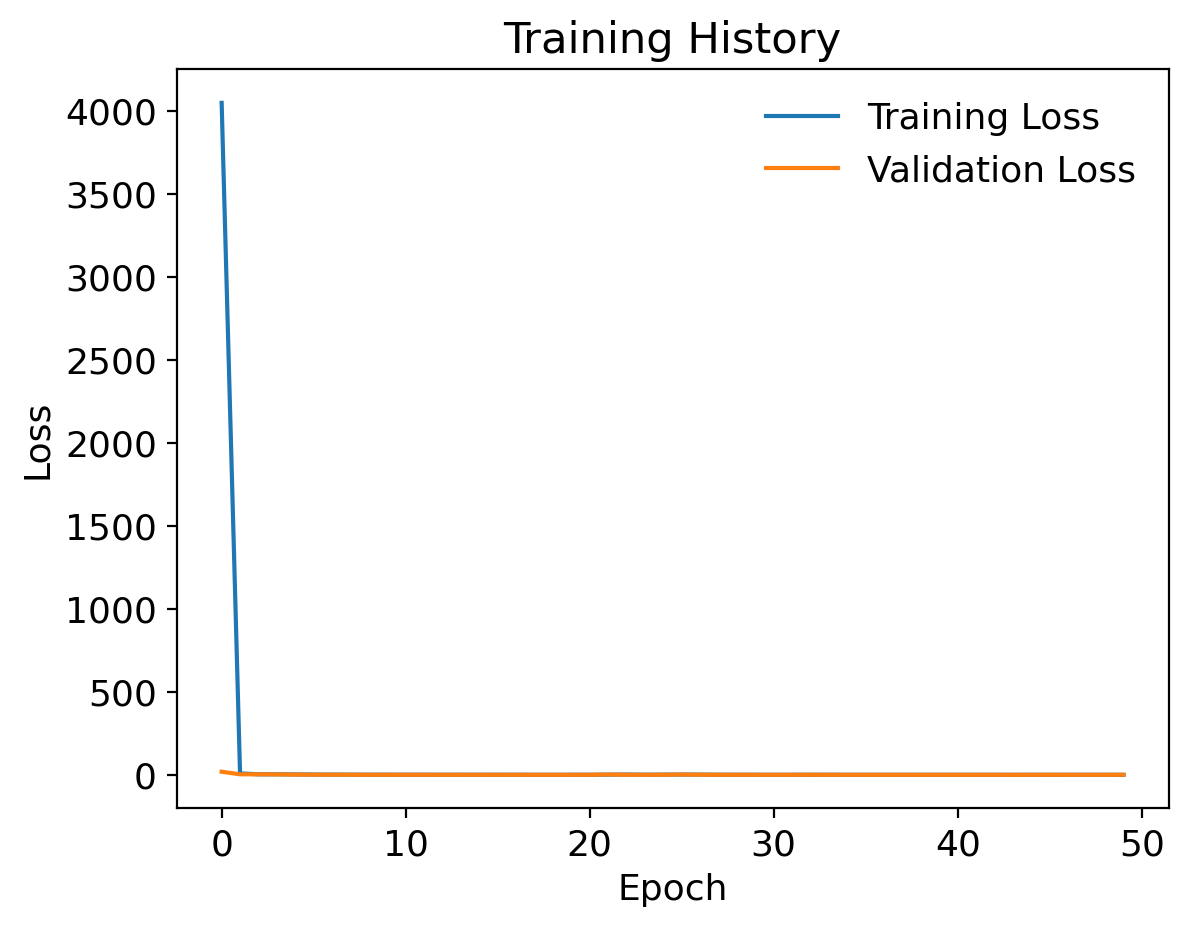

In [13]:
plot_history(train_losses, val_losses)

# 4. Evaluate the VAE model

We assess the trained model on test data by reconstructing temperature fields. Visualizations compare the reconstructed fields with the original data, and we explore the effect of perturbing latent dimensions to understand how the VAE encodes variability.

In [14]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

vae.eval()
predictions = []
with torch.no_grad():
   for (batch_y,) in test_loader:
       recon, mu, logvar = vae(batch_y.to(device))  # unpack the tuple
       predictions.append(recon.cpu().numpy())

y_test_pre = np.concatenate(predictions, axis=0)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)
y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                              'latitude': X_test_xr.latitude.values, 
                              'longitude': X_test_xr.longitude.values},
                      data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

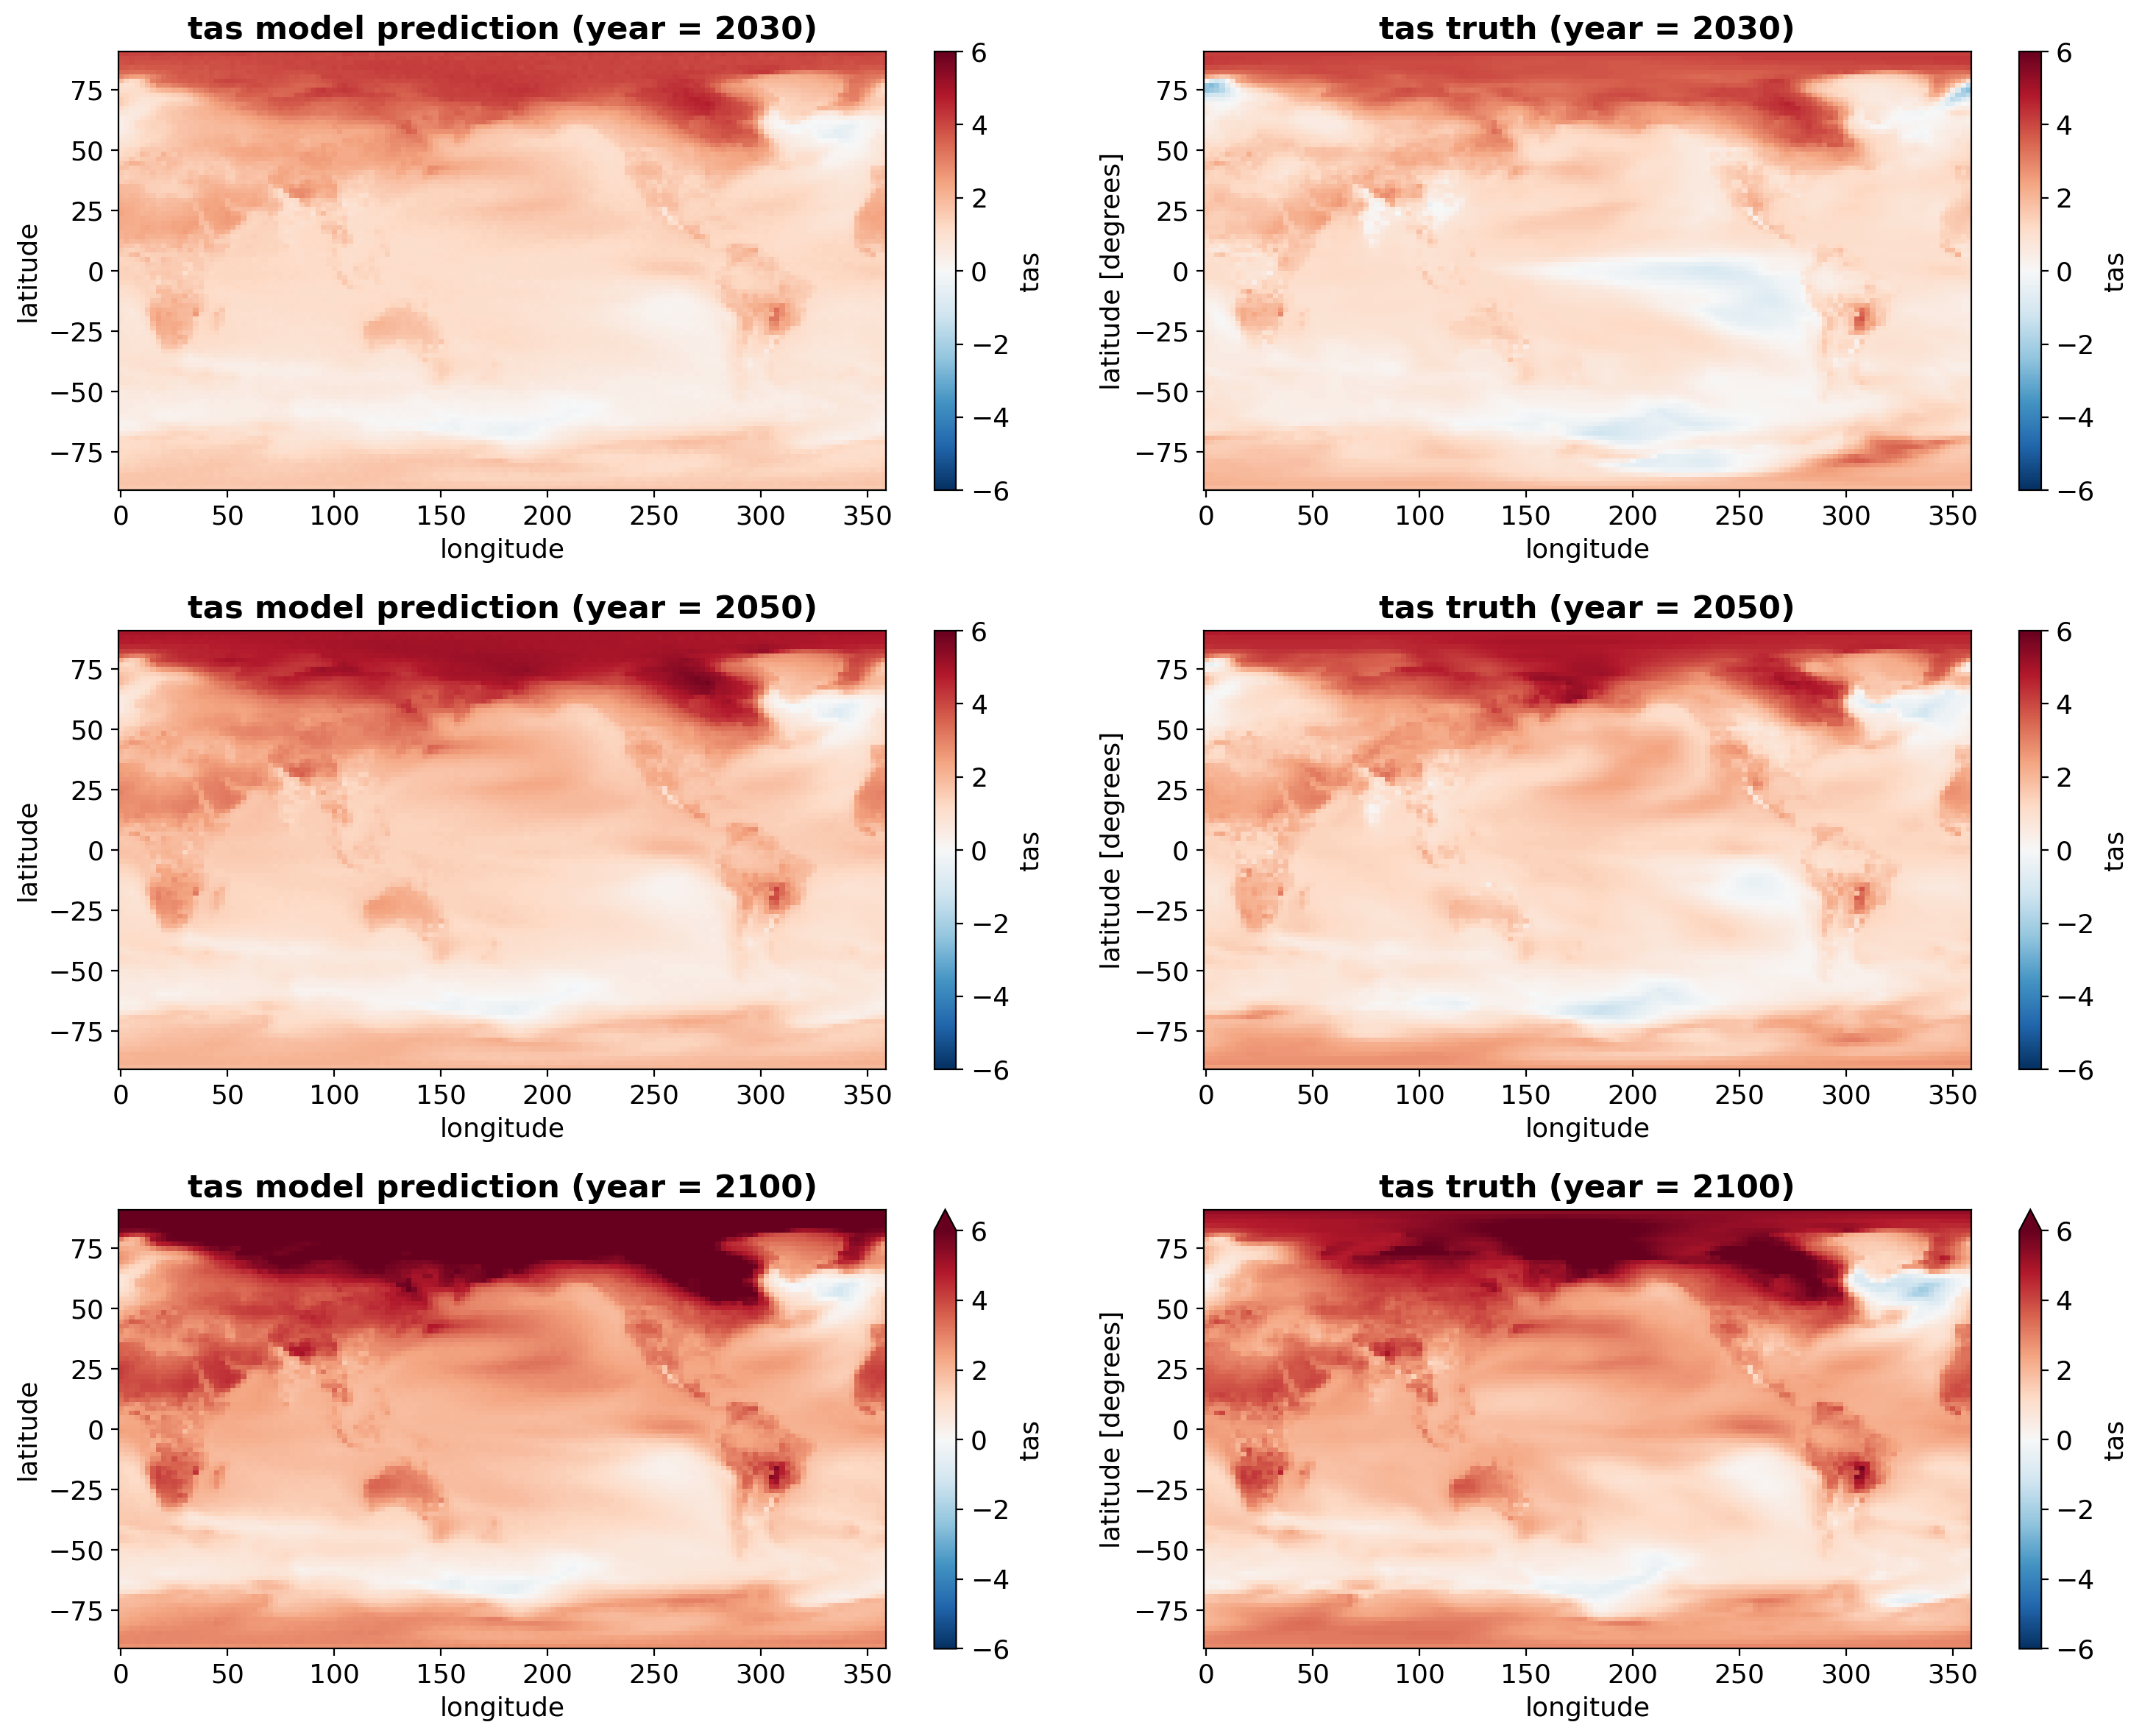

In [15]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

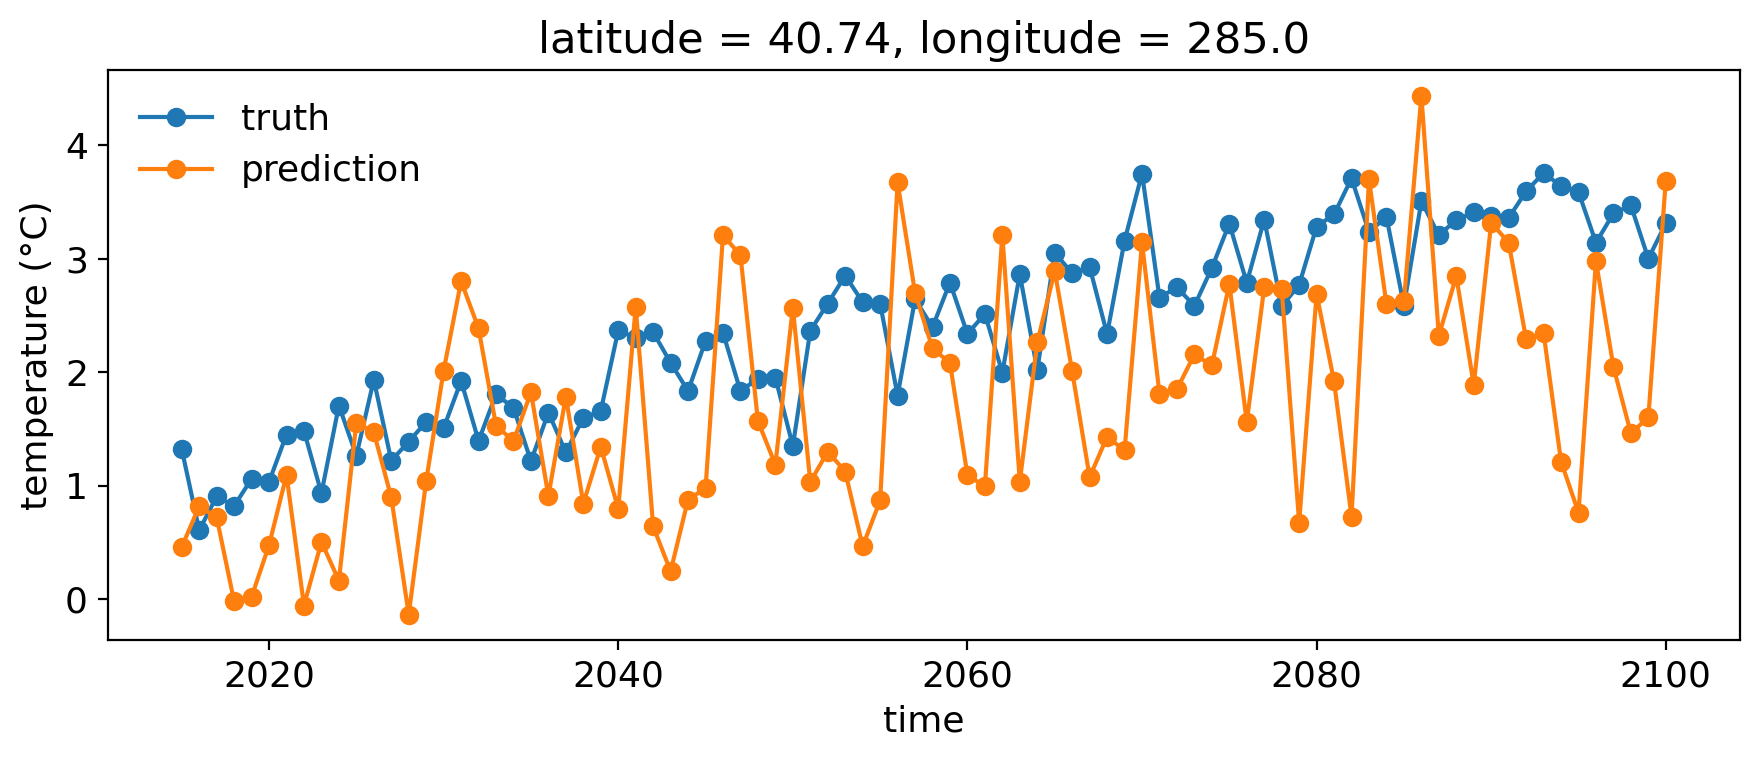

In [16]:
lat = 40.7128
lon = -74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='truth')
y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='prediction')

ax.legend()
ax.set_ylabel('temperature (°C)')

plt.tight_layout()

In [17]:
vae.eval()
with torch.no_grad():
    # Encode test data: take the mean as the latent representation
    mu, logvar = vae.encoder(torch.FloatTensor(y_test_flat).to(device))
    z_all = mu.cpu().numpy()  # use mu for deterministic exploration

# Compute std per latent dimension
z_std = z_all.std(axis=0)
z_vary = []

# Perturb each latent dimension individually
for dim in range(latent_dim):
    z_pert = np.copy(z_all)
    z_pert[0, dim] += 10*z_std[dim]  # increase first sample's dim by 2 std
    z_vary.append(z_pert)

y_test_perturbed = []

for z_pert in z_vary:
    z_tensor = torch.FloatTensor(z_pert).to(device)
    with torch.no_grad():
        y_pred = vae.decoder(z_tensor).cpu().numpy()  # decode using VAE decoder
    y_pred = y_pred.reshape(y_test_flat.shape[0], n_lat, n_lon)
    y_test_perturbed.append(
        xr.Dataset(
            coords={
                'time': y_test_xr.time.values,
                'latitude': y_test_xr.latitude.values,
                'longitude': y_test_xr.longitude.values
            },
            data_vars={'tas': (['time','latitude','longitude'], y_pred)}
        )
    )


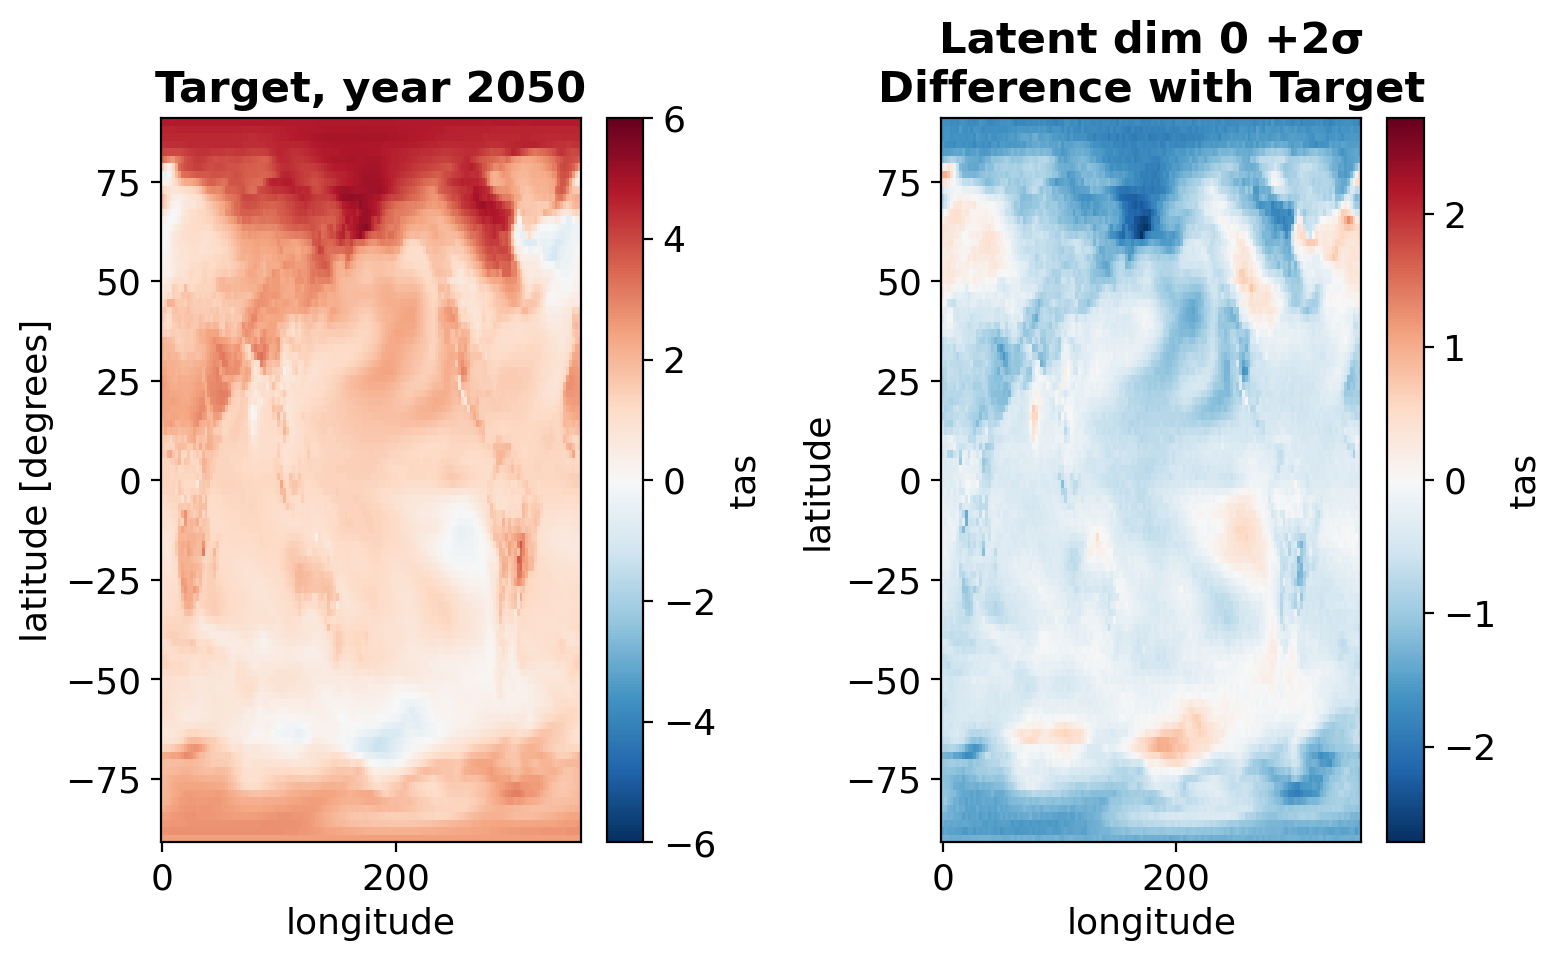

In [18]:
yrs = [2050]  # year to visualize
vmin, vmax = -6, 6
cmap = 'RdBu_r'

n_dims = latent_dim
fig, axes = plt.subplots(nrows=1, ncols=n_dims+1, figsize=(4*(n_dims+1), 5))

y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
axes[0].set_title(f'Target, year {yrs[0]}', fontweight='bold')

for i in range(n_dims):
    diff = y_test_perturbed[i].tas - y_test_xr.tas
    diff.sel(time=yrs[0]).plot(ax=axes[i+1], cmap=cmap)
    axes[i+1].set_title(f'Latent dim {i} +2σ\nDifference with Target', fontweight='bold')

plt.tight_layout()